# Heart Disease Prediction Analysis

# Introduction

This notebook presents an analysis of heart disease prediction using machine learning techniques. We utilize the Framingham Heart Study dataset to build and evaluate a logistic regression model for predicting the 10-year risk of coronary heart disease (CHD).

## Dataset Information

The Framingham Heart Study dataset contains information from a long-term cardiovascular study on residents of Framingham, Massachusetts. It includes various risk factors and the incidence of CHD over a 10-year period.

Link to data: https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea?select=train.csv

Key features in the dataset include:
- Demographic information (age, sex, education)
- Behavioral factors (smoking status, cigarettes per day)
- Medical history (BP medication, prevalent stroke, prevalent hypertension, diabetes)
- Physical measurements (total cholesterol, systolic BP, diastolic BP, BMI, heart rate, glucose)

Target variable:
- TenYearCHD: 10-year risk of CHD (0 = No, 1 = Yes)

## Objectives

1. Data Preprocessing: Clean and prepare the dataset for analysis.
2. EDA: Understand the distribution and relationships of variables.
3. Model Development: Build a logistic regression model to predict CHD risk.
4. Model Evaluation: Assess the model's performance using various metrics.
5. Optimization: If necessary, use methods to improve the model based on its classification metrics.
6. Results Interpretation: Analyze the model's predictions and discuss implications.



# 1. Data Preprocessing

In [4]:
%%capture
! pip install Plotly
! pip install cufflinks
! pip install chart-studio

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import cufflinks as cf
import seaborn as sns
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [6]:
df = pd.read_csv("/content/train.csv", index_col=0)

In [7]:
df.shape

(3390, 16)

In [8]:
df.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
id,,,,,,,,,,,,,,,,
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 450.2+ KB


In [10]:
df.isnull().sum()

,0
age,0
education,87
sex,0
is_smoking,0
cigsPerDay,22
BPMeds,44
prevalentStroke,0
prevalentHyp,0
diabetes,0
totChol,38


This shows that there are many columns with null values.

These can be handled either by dropping rows entirely or by using some sort of filling method.

A common filling method is mean/mode imputation.

For columns such as "cigsPerDay", it is quite plausible that a NaN value simply means zero cigarretes, in which case filling NaNs with 0.0 would be appropriate. Since there is a column for "is_smoking" and also for "cigsPerDay", this hypothesis can be tested.

In [11]:
df[["is_smoking","cigsPerDay"]][df["cigsPerDay"].isnull()]

,is_smoking,cigsPerDay
id,,
422,YES,NaN
466,YES,NaN
469,YES,NaN
491,YES,NaN
538,YES,NaN
767,YES,NaN
1461,YES,NaN
1467,YES,NaN
1597,YES,NaN


This showed that the rows which had NaN for cigsPerDay did not mean zero cigsPerDay. The data is simply missing.

The problem with simply dropping rows is that a lot of data will be lost (around 10%).

Therefore, I decided that imputation was more appropriate. It is best to impute by mean if the distribution is Normal, by median if it skewed, and by mode if it is a categorical variable.

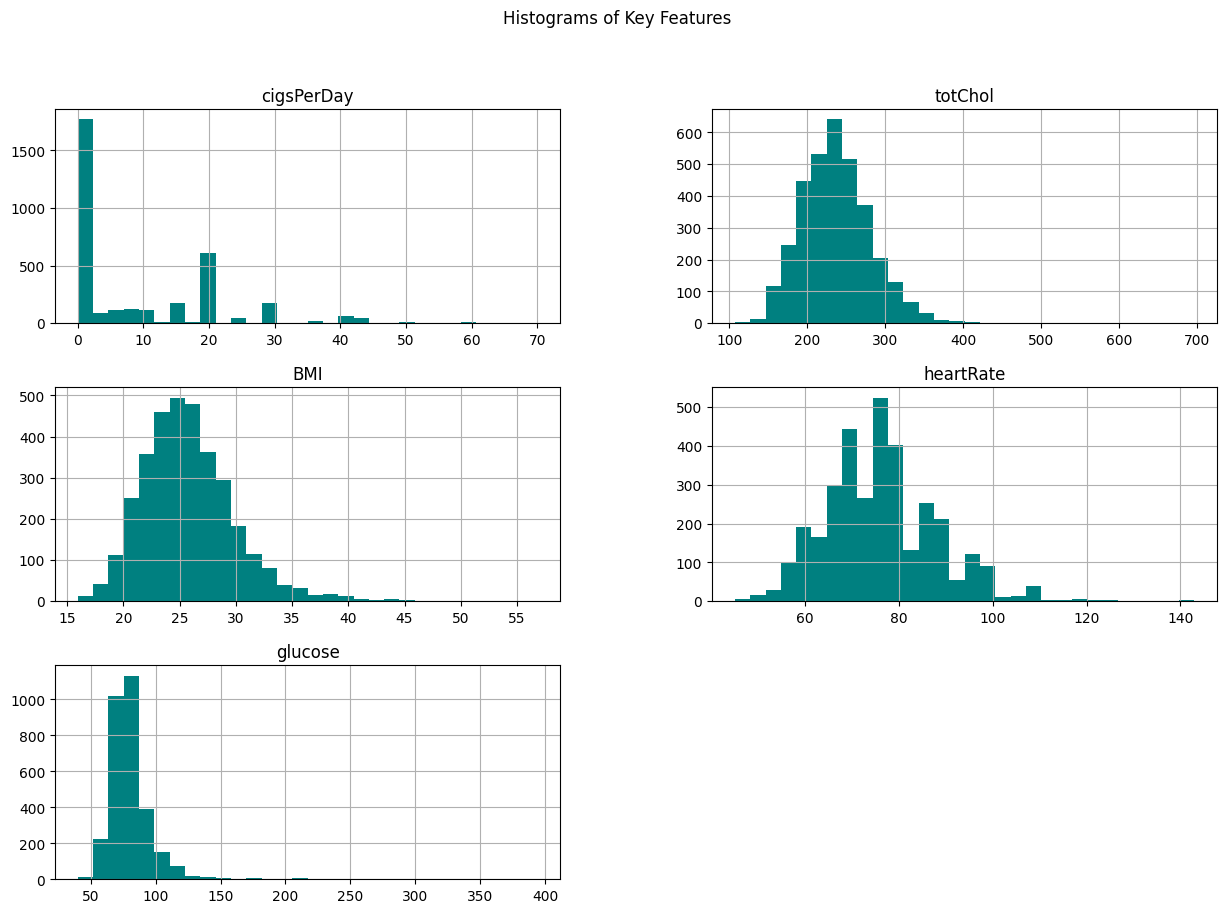

In [12]:
df[['cigsPerDay', 'totChol', 'BMI', 'heartRate', 'glucose']].hist(bins=30, figsize=(15, 10), color='teal')
plt.suptitle('Histograms of Key Features')
plt.show()

The distribution for cigsPerDay is clearly not Normal so median imputation is best.

The other distributions are closer to Normal with a slight skew. So mean imputation could work here. However, they tend to have outliers at the upper end which could affect the mean so median imputation is the safer option.

In [13]:
df['education'] = df['education'].fillna(df['education'].mode()[0])
df['BPMeds'] = df['BPMeds'].fillna(df['BPMeds'].mode()[0])

df['cigsPerDay'] = df['cigsPerDay'].fillna(df['cigsPerDay'].median())
df['totChol'] = df['totChol'].fillna(df['totChol'].median())
df['BMI'] = df['BMI'].fillna(df['BMI'].median())
df['heartRate'] = df['heartRate'].fillna(df['heartRate'].median())
df['glucose'] = df['glucose'].fillna(df['glucose'].median())

Encode the "sex" and "is_smoking" columns so that numerical analysis can be performed.

In [14]:
df["sex"] = df["sex"].map(dict(M=1, F=0))
df["is_smoking"] = df["is_smoking"].map(dict(YES=1, NO=0))

In [15]:
df.duplicated().any()

False

Another thing to consider is outliers.

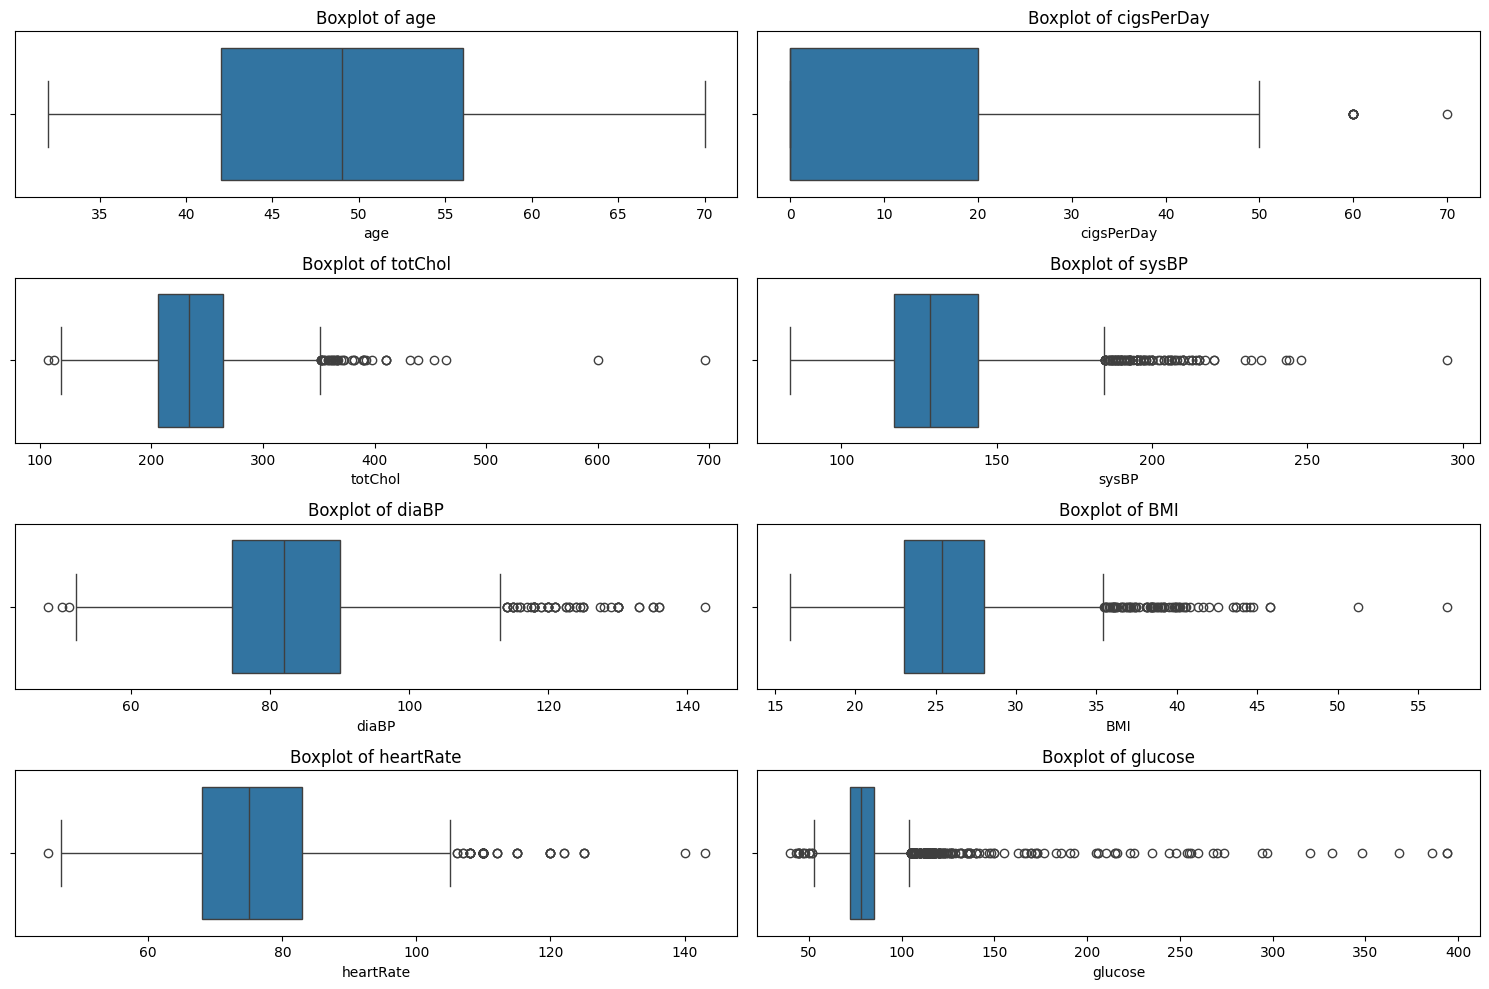

In [16]:
numerical_columns = ["age", "cigsPerDay", "totChol", "sysBP",
                     "diaBP", "BMI", "heartRate", "glucose"]

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()

There are some values that are very high:
* totChol of ~700
* sysBP of ~ 290
* BMI of ~57
* diaBP of ~ 140
* heartRate of ~140
* glucose of ~400

However, none of these values are medically impossible. Therefore it may not be appropriate to classify them as errors and remove them.

A more balanced approach would be to cap variables with outliers at the 99th percentile.

In [17]:
def cap_outliers(df, column, lower_percentile=1, upper_percentile=99):
    lower_cap = df[column].quantile(lower_percentile / 100)
    upper_cap = df[column].quantile(upper_percentile / 100)
    df[column] = df[column].clip(lower=lower_cap, upper=upper_cap)
    return df

columns_to_cap = ['cigsPerDay', 'totChol', 'sysBP', 'diaBP',
                  'BMI', 'heartRate', 'glucose']

for column in columns_to_cap:
    df = cap_outliers(df, column)

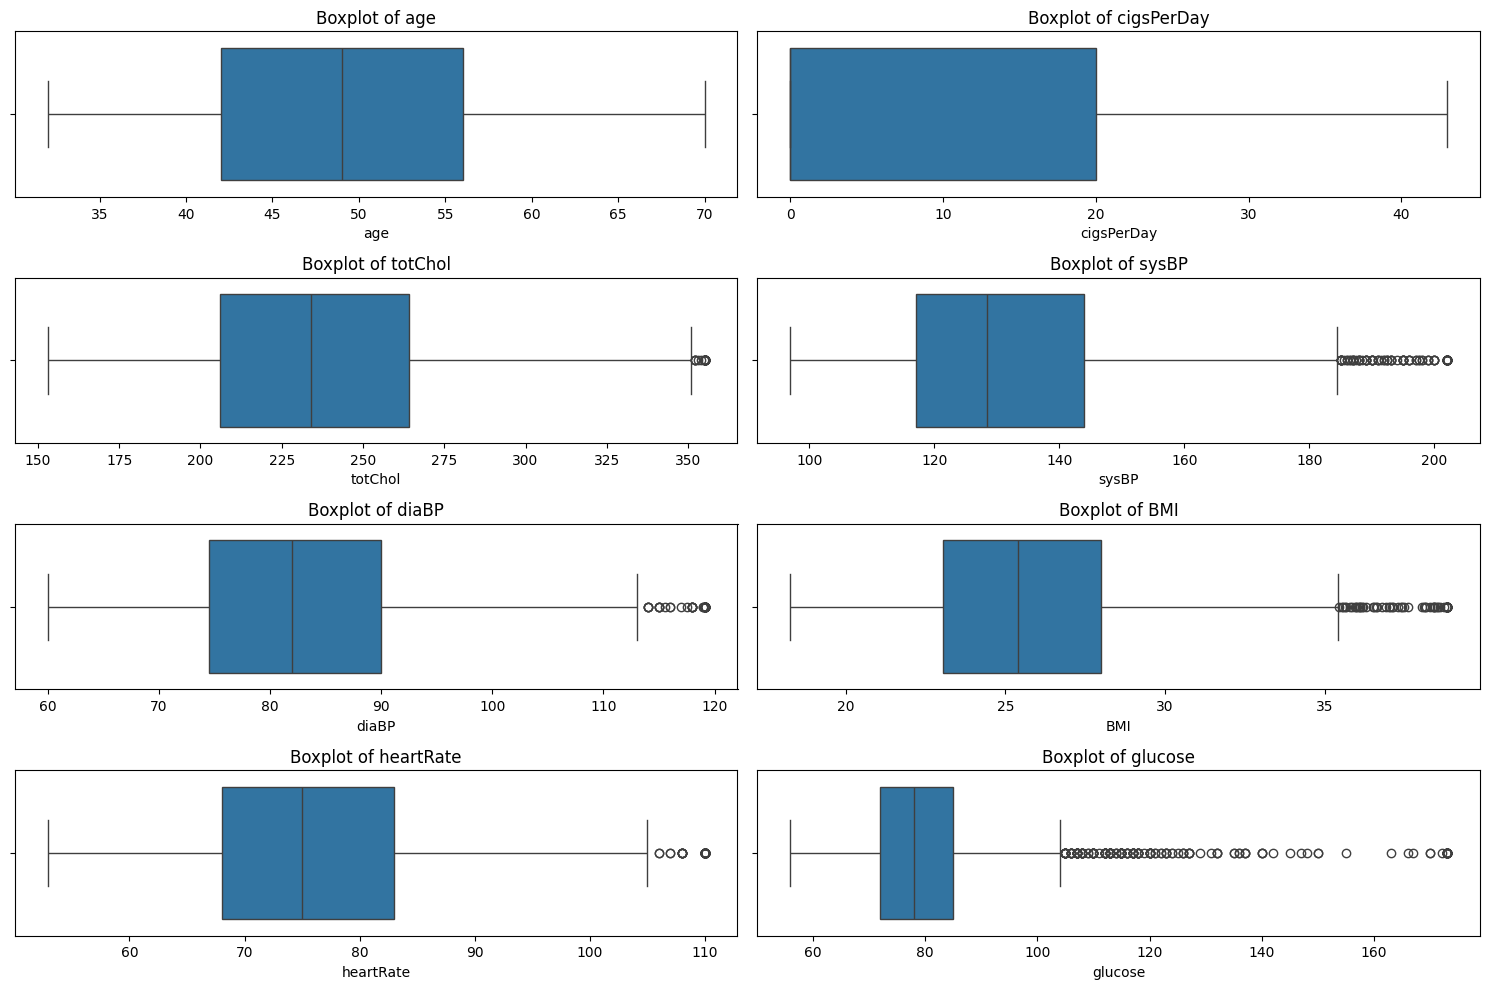

In [18]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()

#EDA

In [19]:
df.describe()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000,3390.000000
mean,49.542183,1.946018,0.432743,0.497640,8.948968,0.029499,0.006490,0.315339,0.025664,236.692254,132.479056,82.840779,25.768369,75.941965,80.930973,0.150737
std,8.592878,1.017568,0.495529,0.500068,11.642356,0.169224,0.080309,0.464719,0.158153,42.723486,21.610756,11.678433,3.954166,11.693615,16.404843,0.357846
min,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,153.000000,96.945000,60.000000,18.256700,52.890000,56.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,74.500000,23.030000,68.000000,72.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.500000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,1.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.000000,27.997500,83.000000,85.000000,0.000000
max,70.000000,4.000000,1.000000,1.000000,43.000000,1.000000,1.000000,1.000000,1.000000,355.110000,202.055000,119.110000,38.835400,110.000000,173.000000,1.000000


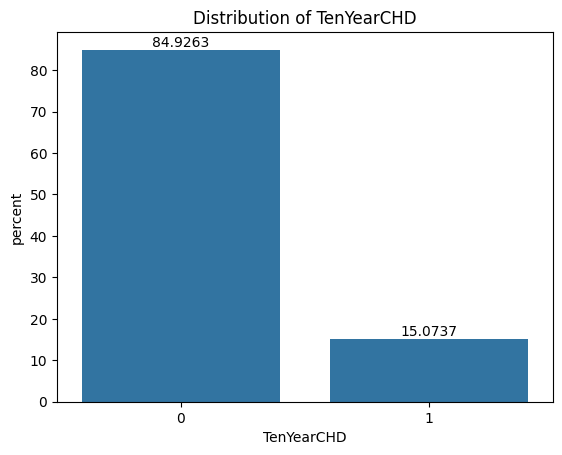

In [20]:
ax = sns.countplot(x='TenYearCHD', data=df, stat='percent')
ax.bar_label(ax.containers[0])
plt.title('Distribution of TenYearCHD')
plt.show()

The target variable appears to be skewed around 15% positive cases compared to around 85% negative cases. This imbalance should be addressed during model training.

I did some EDA to get an idea of which variables should be included in the regression model.

One way to go about this is to check for multicollinearity.

Start by selecting all features but not the target.

In [21]:
features = ['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
               'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol',
               'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

X = df[features]

Add a constant (intercept) to the model.

In [22]:
X = add_constant(X)

Calculate VIF for each feature

In [23]:
vif_df = pd.DataFrame()
vif_df['Feature'] = X.columns
vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_df)

            Feature         VIF
0             const  212.452978
1               age    1.391269
2         education    1.057629
3               sex    1.214344
4        is_smoking    2.567938
5        cigsPerDay    2.702927
6            BPMeds    1.103087
7   prevalentStroke    1.021247
8      prevalentHyp    2.110076
9          diabetes    1.440223
10          totChol    1.122898
11            sysBP    3.794062
12            diaBP    2.907217
13              BMI    1.246319
14        heartRate    1.096880
15          glucose    1.463608


From what I read online, a VIF between 1 and 5 means moderate multicollinearity which is usually acceptable, whilst a VIF more than 5 means high multicollinearity which is a problem.

In the present case, there do not appear to be any problematic VIF scores.

However, it can be easily understood that there is multicollinearity between columns like "is_smoking" and "cigsPerDay".

The same can be said for "sysBP" and "diaBP" and also "prevalentHyp". (Prevalence of hypertension is defined as having sysBP≥140 or diastolic blood pressure ≥90 mmHg)

This was confirmed by the correlation matrix.

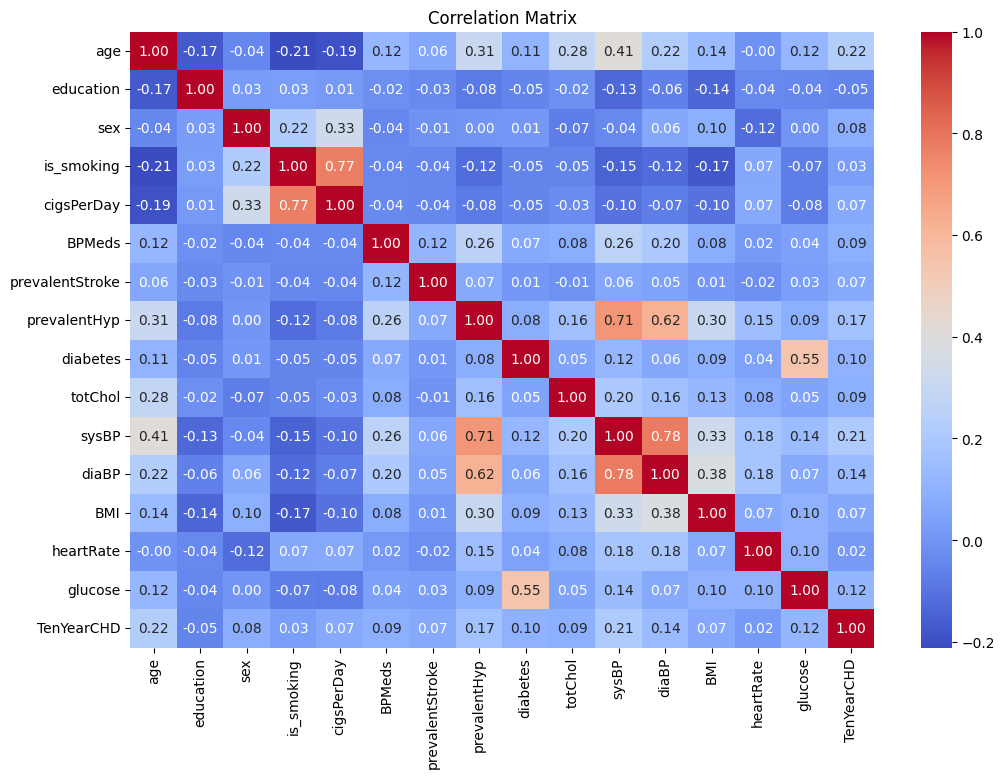

In [24]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [25]:
target_corr = corr_matrix['TenYearCHD'].sort_values(ascending=False)
print("Correlation with TenYearCHD:")
print(target_corr)

Correlation with TenYearCHD:
TenYearCHD         1.000000
age                0.224927
sysBP              0.210185
prevalentHyp       0.166544
diaBP              0.137128
glucose            0.118035
diabetes           0.103681
totChol            0.093284
BPMeds             0.087349
sex                0.084647
cigsPerDay         0.068636
prevalentStroke    0.068627
BMI                0.067031
is_smoking         0.034143
heartRate          0.020386
education         -0.051388
Name: TenYearCHD, dtype: float64


The strongest correlations relating to the target variable are:

Age with a correlation of 0.22

Systolic Blood Pressure with a correlation of 0.21

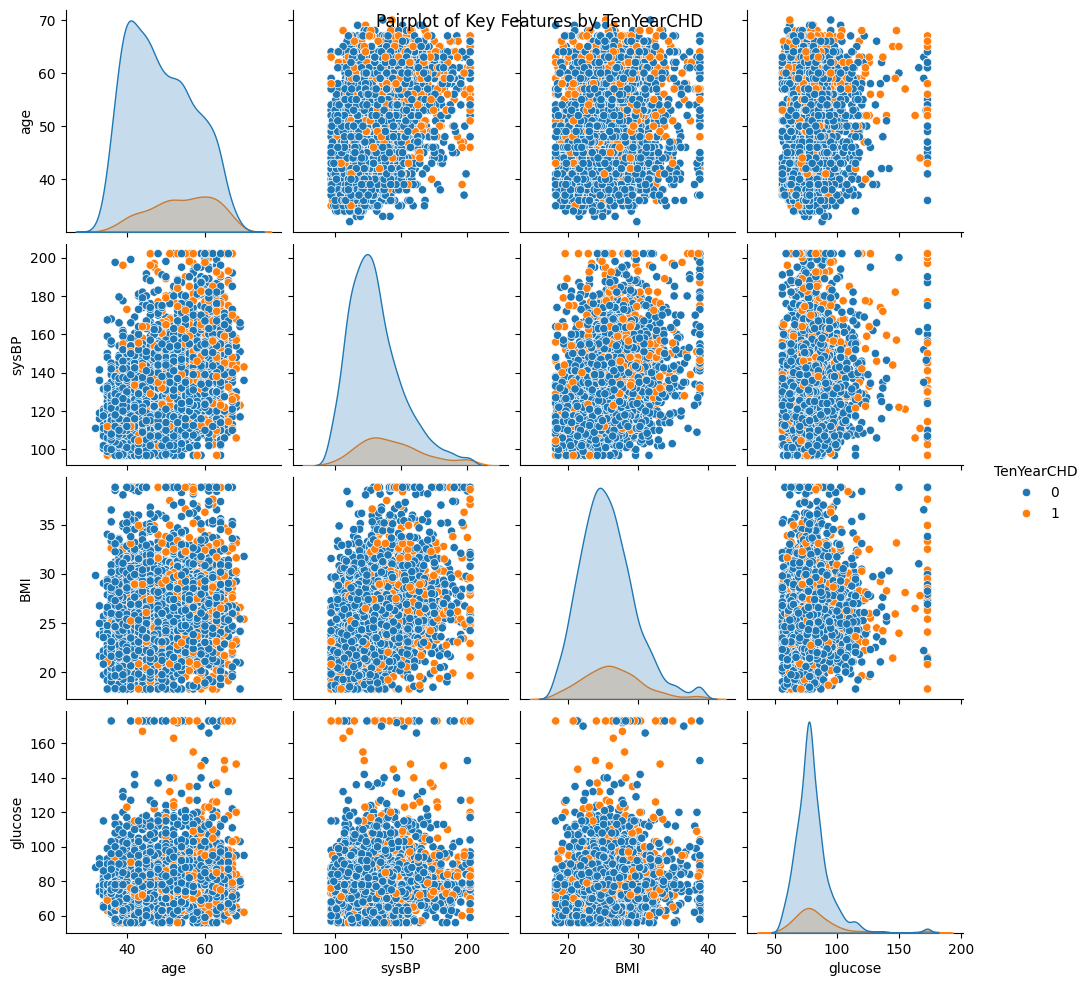

In [26]:
sns.pairplot(df, vars=['age', 'sysBP', 'BMI', 'glucose'], hue='TenYearCHD')
plt.suptitle('Pairplot of Key Features by TenYearCHD')
plt.show()

From this EDA, age, sysBP and prevalentHyp all seem like they are features that should be included in the regression model.

Also, from research and general domain knowledge, cigsPerDay, BMI, diabetes,  and totChol are commonly associated with CHD risk. It is also known that men generally have a higher CHD risk than women.

It should also be noted that logistic regression assumes normally distributed variables. However my earlier histograms and boxplots show that there are varying degrees of skew in many of the features.

So I also did some EDA to investigate this in more detail.

In [27]:
skewness = df[numerical_columns].skew()
print(skewness)

age           0.225796
cigsPerDay    1.108552
totChol       0.393333
sysBP         0.948800
diaBP         0.578842
BMI           0.722090
heartRate     0.549974
glucose       2.609988
dtype: float64


A skewness magnitude more that 0.5 is considered moderately skewed. And more than 1.0 is considered heavily skewed.

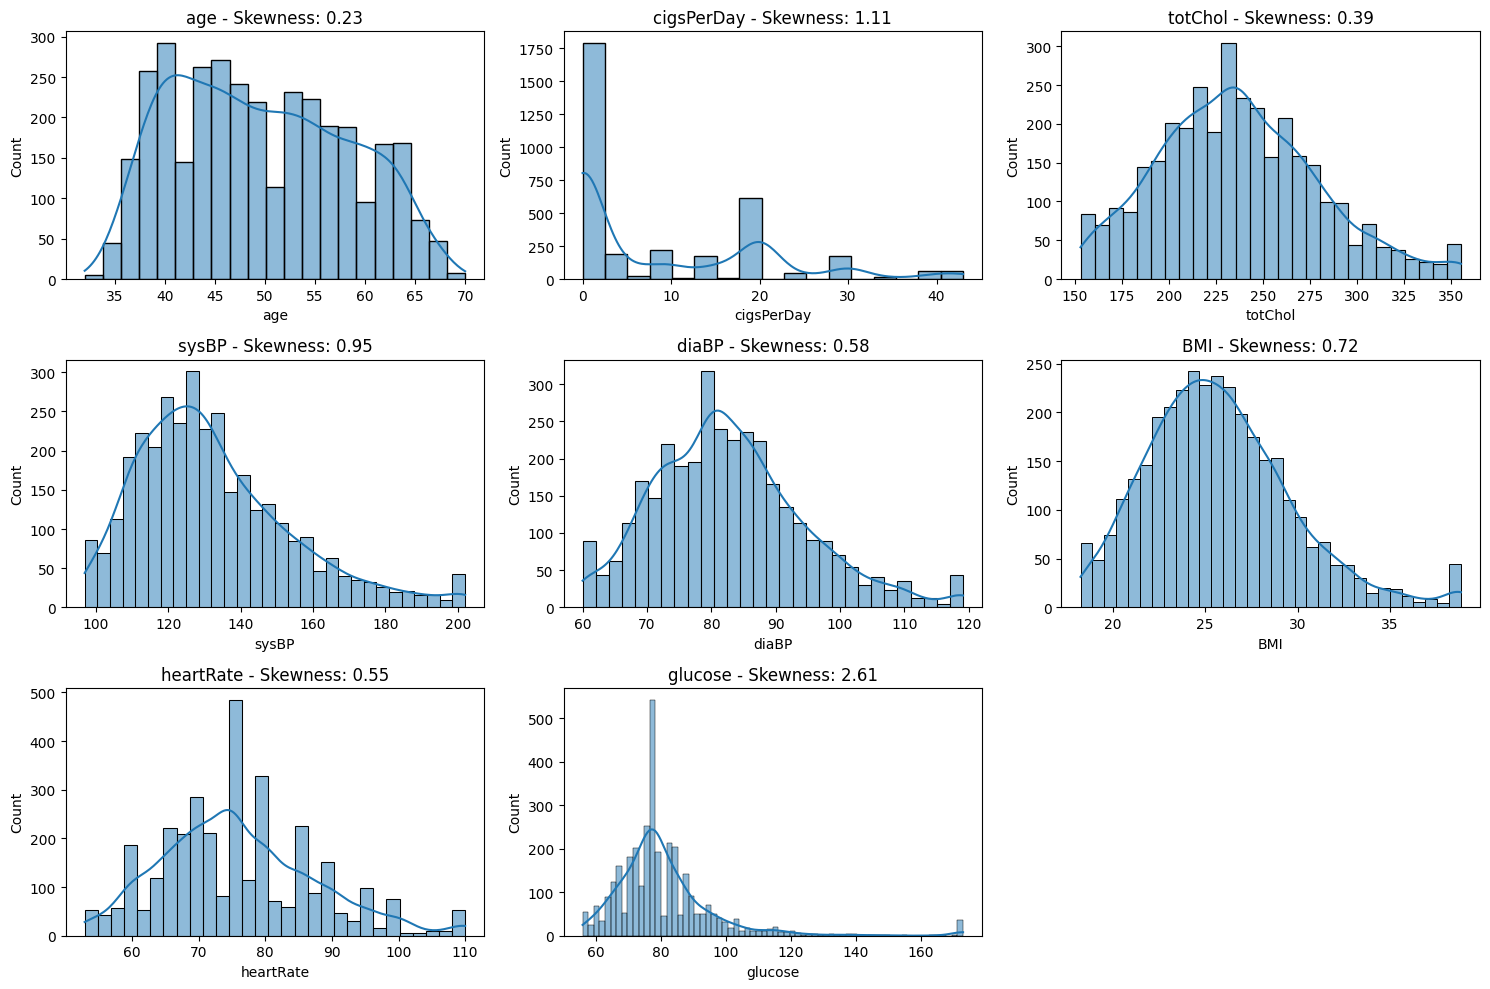

In [28]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[column], kde=True)
    plt.title(f'{column} - Skewness: {df[column].skew():.2f}')
plt.tight_layout()
plt.show()

In [29]:
def sqrt_transform(x):
    return np.sqrt(x - x.min())

skewed_columns = skewness[abs(skewness) > 0.5].index

for column in skewed_columns:
    df[f"{column}_sqrt"] = sqrt_transform(df[column])

In [30]:
new_numerical_columns = ["age", "cigsPerDay_sqrt", "totChol", "sysBP_sqrt",
                     "diaBP_sqrt", "BMI_sqrt", "heartRate_sqrt", "glucose_sqrt"]

new_skewness = df[new_numerical_columns].skew()
print(new_skewness)

age                0.225796
cigsPerDay_sqrt    0.468750
totChol            0.393333
sysBP_sqrt        -0.080723
diaBP_sqrt        -0.590199
BMI_sqrt          -0.390695
heartRate_sqrt    -0.484709
glucose_sqrt       0.529410
dtype: float64


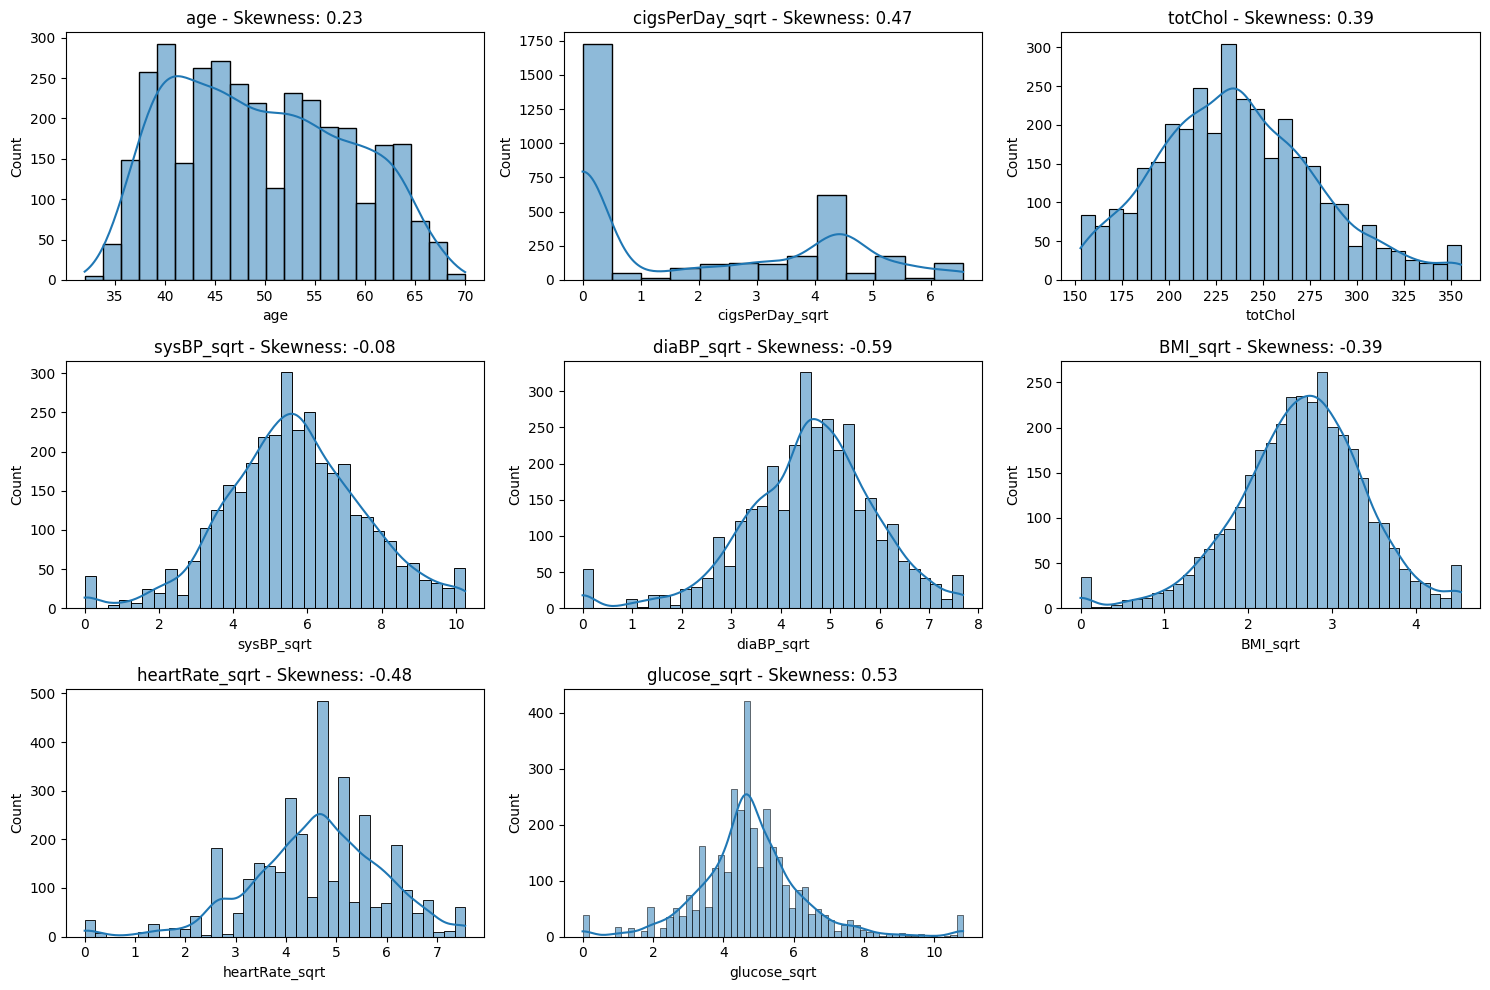

In [31]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(new_numerical_columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[column], kde=True)
    plt.title(f'{column} - Skewness: {df[column].skew():.2f}')
plt.tight_layout()
plt.show()

It can be seen that a square root transformation has reduced the skewness of most variables.

#Logistic Regression

Separate the features and the target variable.

In [32]:
target = 'TenYearCHD'
features = ["age", "cigsPerDay_sqrt", "totChol", "sysBP_sqrt",
                      "BMI_sqrt",	"heartRate_sqrt",	"glucose_sqrt", "sex",
                      "BPMeds", "prevalentStroke", "diabetes"]

X = df[features]
y = df[target]

Split the dataset.

Stratify since the target variable is imbalanced.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df["TenYearCHD"])

Separate numerical and categorical variables.

In [34]:
numerical_features = ["age", "cigsPerDay_sqrt", "totChol", "sysBP_sqrt",
                      "BMI_sqrt",	"heartRate_sqrt",	"glucose_sqrt"]
categorical_features = ["sex", "BPMeds", "prevalentStroke", "diabetes"]

For the numerical columns, do standard scaling.

Introduce the StandardScaler() class.

This allows us to call the scaler.fit() and scaler.transform() methods.

The main idea is to standardize the features before applying any machine learning model. (i.e. make μ = 0 and σ = 1)

In more detail, scaler.fit() computes the μ and σ of the raw features.

Then, scaler.transform() uses the μ and σ to perform standardisation of the raw features by centering and scaling them.

fit_transform() is just both of these turned into a single operation.

In [35]:
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

Introduce the LogisticRegression() class.

This allows us to call the log_reg.fit() method.

Fitting the model to the training data is essentially the training part of the modeling process. It finds the coefficients for the logistic regression equation.

In [36]:
log_reg = LogisticRegression(class_weight="balanced")
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

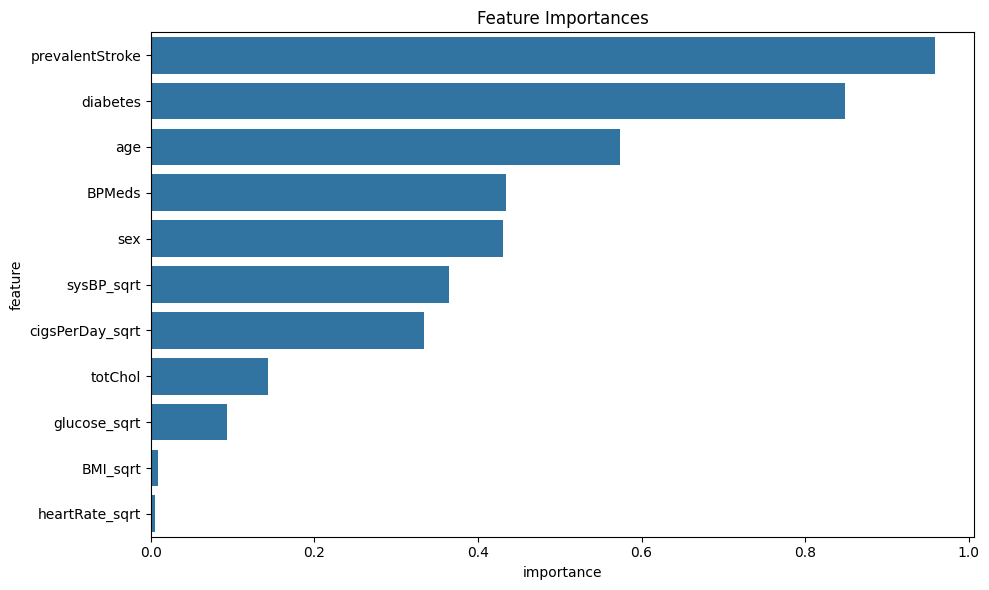

In [37]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': abs(log_reg.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importances')
plt.tight_layout()

Printing the actual coefficient values out:

In [38]:
for feature, coef in zip(X.columns, log_reg.coef_[0]):
    print(f"{feature}: {coef:.4f}")

age: 0.5738
cigsPerDay_sqrt: 0.3346
totChol: 0.1434
sysBP_sqrt: 0.3647
BMI_sqrt: -0.0085
heartRate_sqrt: 0.0056
glucose_sqrt: 0.0926
sex: 0.4310
BPMeds: 0.4347
prevalentStroke: 0.9588
diabetes: 0.8489


Now that the model has been trained, it can be used to make predictions.

In [39]:
y_pred = log_reg.predict(X_test)

The percentage of CHD results that our model successfully predicted is represented by accuracy.

Using various train vs test splits of the dataset will generally give an accuracy score of around 0.6.

This means that the model correctly predicts someone's CHD status 60% of the time.

However, as discussed later, accuracy is not the best classification metric for this mode.

In [40]:
accuracy_score(y_test, y_pred)

0.6460176991150443

Now create a confusion matrix.

True Negative (Top-Left Quadrant)

False Positive (Top-Right Quadrant)

False Negative (Bottom-Left Quadrant)

True Positive (Bottom-Right Quadrant)

In [41]:
cm = confusion_matrix(y_test, y_pred)

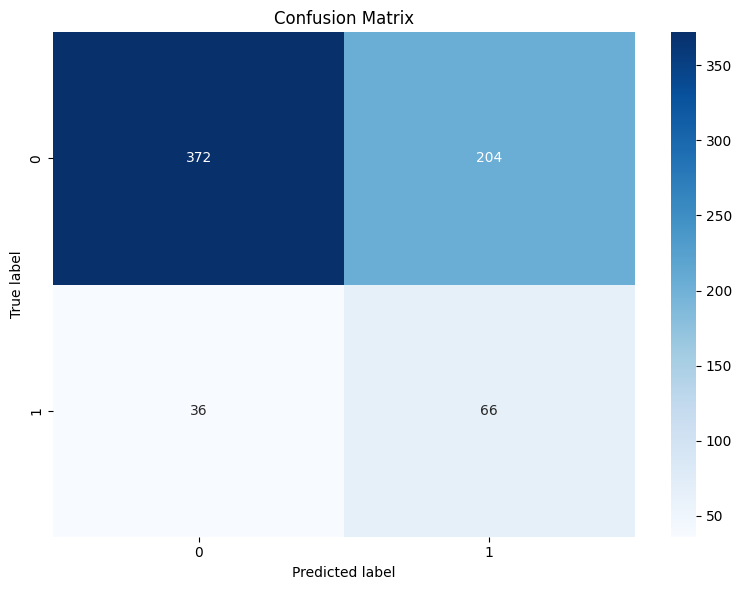

In [42]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.65      0.76       576
           1       0.24      0.65      0.35       102

    accuracy                           0.65       678
   macro avg       0.58      0.65      0.56       678
weighted avg       0.81      0.65      0.70       678



Some classification metrics of importance are accuracy, precision and recall.

Let's consider the value of each for the present data.

As noted above, the model achieves an accuracy of about 85% on test sets. However, it's important to note that there is a high imbalance of classes. In the data there are far more cases of not having CHD than having CHD. Therefore, a broken model that simply always predicted not having CHD would have quite a high accuracy. Therefore accuracy may not be the best classification metric for this data.

Precision answers the question: how often the positive predictions are correct? Above we can see that for the case of people having CHD, the precision is high. This means that all times the model says someone has CHD, they did indeed have CHD. This is good if the cost of a false positive is high, but precision does not consider false negatives.

This is a major problem in our case because, in the context of medical dignosis, a false positive can lead to wasted time and money, however a false negative can result in death. Therefore the cost of a false negative is much worse than the cost of a false positive.

Recall measures how often the model correctly identifies positive instances. This means the recall score will be low if there are a lot of false negatives. Above we can see that for the positve case we have a low recall. This means that the model performs much better in predicting if someone **doesn't** have CHD than in predicting if someone **does** have CHD. I.e. the model is prone to false negatives.

In the present case, recall is the most appropriate metric to use for assessing the effectiveness of the model. And since our recall is low, our model is not currently effective.


F1 score is also good for assessing the model. It combines the precision and recall scores of a model.

Typically, an F1 score > 0.9 is considered excellent. A score between 0.8 and 0.9 is considered good, while a score between 0.5 to 0.8 is considered average. If the F1 score falls below 0.5, then the model is considered to have a poor performance.

It can be seen that the f1 is very low for the positive CHD case.

#New classification threshold

The default classification threshold is 0.5 which means that if the model determines a patient has a >50% probablity of CHD, the model will classify them as being CHD positive.

However, We want to minimize the risk of missing potential CHD cases, even if it means increasing false positives to some extent. We can adjust the classification threshold to achieve this. A safer option might be to have a lower threshold. Meaning that if the model determines that someone has only a low probability of CHD, they will still be classified as CHD positve.

The predict_proba() method returns an array with columns representing the predicted probabilities for each class. In this case the first column is the probability of being CHD negative for each row, and the second column is the probability of CHD positive for each row.

We can use list slicing to get all the CHD positive probabilities.

In [44]:
y_pred_probabilities = log_reg.predict_proba(X_test)[:,1]

We can the calculate an ROC (Receiver Operating Characteristic) curve and AUC (Area Under Curve) to find the best threshold.

In [45]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_probabilities)
roc_auc = auc(fpr, tpr)

Find optimal threshold uing Youden's J statistic.

In [46]:
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds_roc[optimal_idx]

Plot ROC curve.

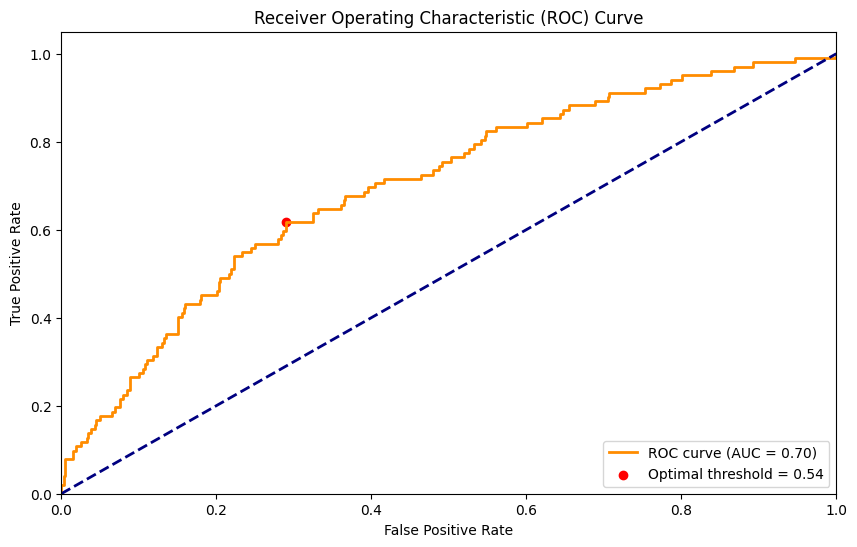

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal threshold = {optimal_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

Turn the entire array of probabilities into a Boolean Mask where True is returned if the probability is more than the optimal ROC threshold.

Instead of True/False, make it 1/0.

In [48]:
y_pred_new_threshold = (y_pred_probabilities >= optimal_threshold).astype(int)

In [49]:
print(classification_report(y_test, y_pred_new_threshold))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80       576
           1       0.27      0.62      0.38       102

    accuracy                           0.70       678
   macro avg       0.59      0.66      0.59       678
weighted avg       0.82      0.70      0.74       678



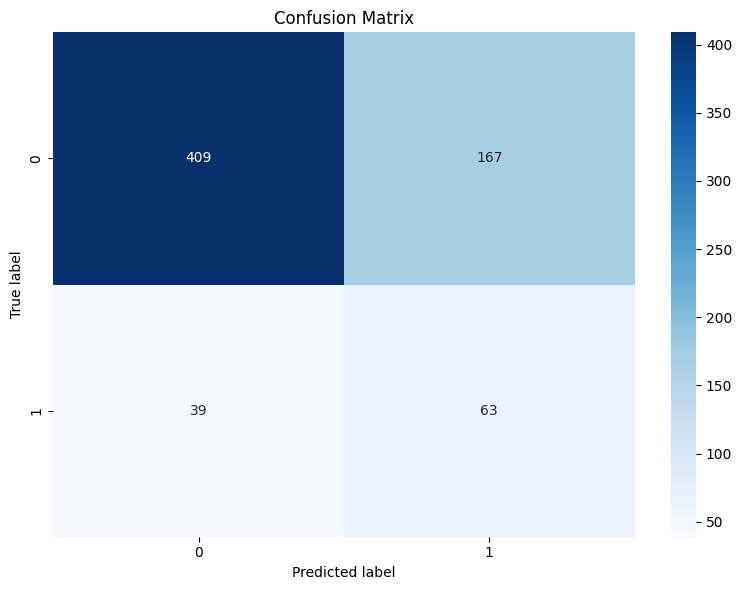

In [50]:
cm_new = confusion_matrix(y_test, y_pred_new_threshold)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

It can be seen that while the accuracy of the model is reduced, there are far less dangerous occurences of false negatives when it comes to predicting if someone has CHD.

The f1 score for the CHD positive case has improve but it still cannot be considered "good".

##Analysis of Model and Implications

The logistic regression model developed in this analysis provides valuable insights into predicting the 10-year risk of CHD. The first model demonstrated strong performance in identifying non-CHD cases, achieving high precision and accuracy. However, it struggled with detecting CHD cases, as evidenced by lower recall rates.

By adjusting the classification threshold, we were able to significantly improve recall for CHD cases, capturing a larger proportion of true positives. This adjustment, however, comes at the cost of increased false positives, which may lead to unnecessary medical interventions or anxiety for individuals incorrectly identified as at risk.

These findings highlight the importance of balancing precision and recall based on the specific context and consequences of false positives and negatives. In clinical settings, where missing a true CHD case could have severe implications, prioritizing recall might be more appropriate.

# Summary and Conclusions

In this analysis, we explored the prediction of CHD risk using logistic regression. Here's a summary of the key steps and findings:

## Main Findings

1. **Data Preprocessing**: Successfully cleaned and prepared the dataset, handling missing values and scaling features for model training.

2. **EDA**: Performed some EDA to get determine which features would be most relevant to the model.

3. **Model Development**: Built a logistic regression model to predict the 10-year risk of CHD.

4. **Model Evaluation**: Evaluated the model using various metrics, including accuracy, precision, recall, and F1-score.
   - The model showed good performance in predicting non-CHD cases but struggled with CHD cases.

5. **Threshold Optimization**: Explored different classification thresholds to improve recall for CHD cases.
   - Lowering the threshold significantly increased recall for CHD cases, but at the cost of precision.

6. **Results Interpretation**: Analyzed the confusion matrices and classification reports to understand the trade-offs between precision and recall.

## Insights

- The logistic regression model is effective in identifying non-CHD cases but requires threshold adjustments to improve CHD case detection.
- Lowering the threshold can help catch more CHD cases, but it increases false positives. A preferable trade-off.

## Suggestions for Further Analysis

1. **Feature Engineering**: Explore additional features or transformations that might improve model performance.

2. **Advanced Models**: Consider using more complex models like Random Forests to capture non-linear relationships.

3. **Cross-Validation**: Implement cross-validation to ensure the model's robustness and generalizability.

4. **Hyperparameter Tuning**: Split the dataset into an additional validation set to perform hyperparameter tuning.

5. **Threshold optimisation**: Compare ROC curve with precision-recall curve.